In [1]:
import _base_path
import json
import numpy as np
import pandas as pd

import matplotlib
if 'init_done' in globals():
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
import matplotlib.pyplot as plt

from resources.spans import SpanCollection

init_done = True

Setting base bath to "c:\Users\Korbi\Desktop\CICLe"


c:\Users\Korbi\Desktop\CICLe\resources\spans.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Load data:

In [2]:
# load data:
incidents = pd.read_csv("../data/incidents/incidents_final.csv", index_col=0)
incidents.drop(columns=[col for col in incidents.columns if 'text' in col], inplace=True)

# parse products:
incidents['product'].fillna('', inplace=True)
incidents['product-raw'].fillna('', inplace=True)
incidents['product-category'].fillna('', inplace=True)
incidents['product-title']    = [SpanCollection.parse(p) for p in incidents['product-title'].fillna('')]

# parse hazards:
incidents['hazard'].fillna('', inplace=True)
incidents['hazard-raw'].fillna('', inplace=True)
incidents['hazard-category'].fillna('', inplace=True)
incidents['hazard-title']     = [SpanCollection.parse(h) for h in incidents['hazard-title'].fillna('')]

# parse suppliers:
incidents['supplier-title']   = [SpanCollection.parse(s) for s in incidents['supplier-title'].fillna('')]

# fill nan-values:
incidents['country'].fillna('na', inplace=True)

def print_column(column:str, n:int=10):
    try:               values = np.unique(np.concatenate(incidents[column].values))
    except ValueError: values = np.unique(incidents[column].values)
    counts = np.array([sum([v in label for label in incidents[column].values]) for v in values])

    idx = np.argsort(counts)[::-1]
    values = values[idx]
    counts = counts[idx]
    
    print(f'Column "{column}" (n = {len(values):d}):\n')
    for v, n in zip(values[:n], counts[:n]):
        print(f'  {v}:{" "*(50-len(v))}{sum([v in label for label in incidents[column].values]):5d}')

# print unique counts:
for c in incidents.columns:
    print(f'  {c}:{" "*(20-len(c))}{len(incidents[c].drop_duplicates()):5d}')

  year:                   29
  month:                  12
  day:                    31
  url:                  7500
  title:                7331
  product:              1258
  product-raw:          1880
  product-category:       23
  product-title:        7548
  hazard:                262
  hazard-raw:            408
  hazard-category:        11
  hazard-title:         7548
  supplier-title:       7548
  language:                6
  country:                15


In [3]:
print(incidents.shape)
incidents.head()

(7548, 16)


,year,month,day,url,title,product,product-raw,product-category,product-title,hazard,hazard-raw,hazard-category,hazard-title,supplier-title,language,country
0,2015,5,26,https://www.fda.gov/Safety/Recalls/ArchiveReca...,2015 - House of Spices (India) Inc. Issues Ale...,dried apricots,dried apricots,fruits and vegetables,(),sulphur dioxide and sulphites,undeclared sulphite,allergens,"(slice(7, 34, None))","(slice(7, 34, None))",en,us
1,2022,5,25,https://www.fda.gov/safety/recalls-market-with...,Supplier J.M. Smucker Co.’s Jif Recall Prompts...,peanuts,peanuts,"nuts, nut products and seeds",(),salmonella,salmonella,biological,"(slice(47, 62, None))","(slice(47, 62, None))",en,us
2,2020,6,2,http://www.cfs.gov.hk/english/whatsnew/whatsne...,*(Updated on 2 June 2020) Not to consume a bat...,apple juice,apple juice,non-alcoholic beverages,"(slice(52, 71, None))",patulin,patulin,chemical,(),(),en,hk
3,2022,7,5,http://www.cfs.gov.hk/english/whatsnew/whatsne...,*(Updated on 5 July 2022) Not to consume smoke...,salmon,chilled smoked salmon,seafood,"(slice(41, 54, None))",listeria monocytogenes,listeria monocytogenes,biological,(),(),en,hk
4,2021,3,20,http://www.fsis.usda.gov/recalls-alerts/avanza...,"Avanza Pasta, LLC Recalls Beef and Poultry Pro...",pasta products,pasta products,other food product / mixed,"(slice(7, 12, None), slice(43, 51, None))",inspection issues,inspection issues,fraud,"(slice(0, 17, None))","(slice(0, 17, None))",en,us


# Plots:

Histograms:

In [4]:
def plot_hist(ax, values, title, n_named=3):
    # count label occurences:
    labels = np.unique(values)
    counts = np.array([sum([l == v for v in values]) for l in labels], dtype=int)

    # sort by counts:
    idx = np.argsort(counts)[::-1]
    labels = labels[idx]
    counts = counts[idx]

    # plot:
    n = len(labels)
    x = np.arange(n, dtype=float)
    
    for i in range(n_named):
        # create lainebeaks in label:
        label = []
        line = ''
        for word in labels[i].split():
            if len(line) + len(word) < 20:
                line += word + ' '
            else:
                label.append(line[:-1])
                line = word  + ' '
        label.append(line[:-1])
        line = ''

        # rescale named bars for better visibility:
        f = 1. if n < 80 else n/80.
        x[i+1:] += (f - 1.) if (i+1) < n_named else (f - 1.)/2.
        
        ax.bar(x[i], counts[i], 0.8*f,
            label='\n'.join(label))

    ax.bar(x[n_named:], counts[n_named:], color='grey')
    ax.set_title(title)
    ax.legend(prop={'size': 8}, loc='upper right')
    ax.set_xticks([])

    # plot support based class sets:
    values_accumulated = np.cumsum(counts[::-1])[::-1]

    high_support = np.nonzero(values_accumulated >= values_accumulated[0] * .67)[0]
    ax.axvspan(
        x[high_support[0]] - .5 * (1. if n < 80 else n/80.), 
        .5 * (x[high_support[-1]] + x[high_support[-1] + 1]),
        facecolor='grey',
        alpha=0.5,
        zorder=0
    )

    low_support = np.nonzero(values_accumulated <= values_accumulated[0] * .33)[0]
    ax.axvspan(
        .5 * (x[low_support[0] - 1] + x[low_support[0]]),
        x[low_support[-1]] + (1. if n < 80 else n/80.),
        facecolor='grey',
        alpha=0.5,
        zorder=0
    )
    
    print(f'{title}: n_high = {sum(counts[high_support]):d}/{len(high_support):d}, n_low = {sum(counts[low_support]):d}/{len(low_support):d}')

    return list(labels[high_support]), list(labels[low_support])


\texttt{hazard-category}: n_high = 2558/1, n_low = 2463/9
\texttt{product-category}: n_high = 3089/2, n_low = 2187/17
\texttt{hazard}: n_high = 2669/3, n_low = 2414/249
\texttt{product}: n_high = 2508/39, n_low = 2485/1060


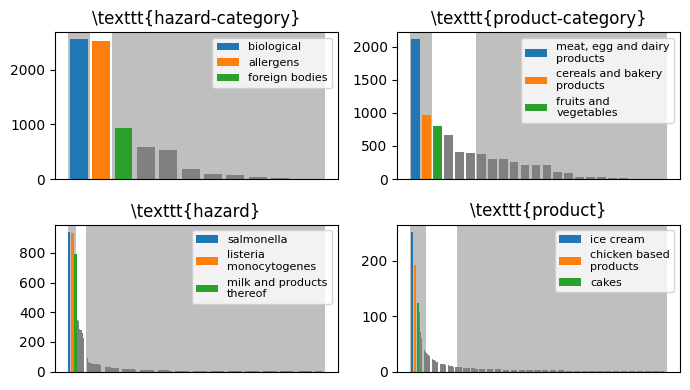

In [5]:
fig, axs = plt.subplots(2, 2, figsize=[7, 4])

support_zones = {}

support_zones['hazard-category']  = plot_hist(axs[0, 0], incidents['hazard-category'].values,  '\\texttt{hazard-category}')
support_zones['product-category'] = plot_hist(axs[0, 1], incidents['product-category'].values, '\\texttt{product-category}')
#support_zones['hazard-raw']       = plot_hist(axs[1, 0], incidents['hazard-raw'].values,       '\\texttt{hazard}')
#support_zones['product-raw']      = plot_hist(axs[1, 1], incidents['product-raw'].values,      '\\texttt{product}')
support_zones['hazard']           = plot_hist(axs[1, 0], incidents['hazard'].values,           '\\texttt{hazard}')
support_zones['product']          = plot_hist(axs[1, 1], incidents['product'].values,          '\\texttt{product}')

with open('../data/incidents/support_zones.json', 'w') as file:
    json.dump(support_zones, file)

plt.tight_layout()
plt.savefig('plots/class_distribution.pdf')

Language Distribution:

In [6]:
def plot(ax, values):
    # get x-values:
    x = np.unique(values[:,0])
    n = len(x)

    # sort x-value:
    x = np.sort(x)

    # get curve names:
    labels = np.unique(values[:,1])

    # count label occurences:
    counts = np.zeros((len(labels), n), dtype=int)
    for v in values:
        counts[labels == v[1], x == v[0]] += 1

    for y, l in zip(counts, labels):
        ax.plot(x, y, label=l)

    ax.legend()

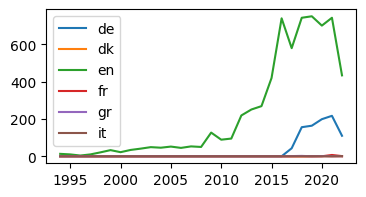

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[4, 2])
plot(ax, incidents[['year','language']].values)
plt.savefig('plots/language_per_year.pdf')